# Simulator

In [1]:
import sys
sys.path.insert(0, "..")
import pandas as pd
import matplotlib.pyplot as plt
from trading_simulator import TradingSimulator, DLSimulator
from dl_solutions.dlsolutions import CryptoDLSolutions
from data_processor.data_processing import DataProcessor
from utils.crypto_utils import ModelAnalysis

Using TensorFlow backend.


## Classic

### Data preparation

In [ ]:
cryptos = ['ADA', 'BTC', 'ETH', 'LTC', 'LNK']
sel = 0

In [ ]:
for crypto in cryptos:
    processor = DataProcessor([crypto])
    sim = TradingSimulator(processor, crypto, strategy = [1, 2, 3, 4, 5, 6, 7], loss_allowed = 0.2, log = False)
    sim.simulate()

In [ ]:
processor = DataProcessor([crypto])
sim1 = TradingSimulator(processor, crypto, strategy = [1], loss_allowed = 0.2)
sim2 = TradingSimulator(processor, crypto, strategy = [2], loss_allowed = 0.2)
sim3 = TradingSimulator(processor, crypto, strategy = [3], loss_allowed = 0.2)
sim4 = TradingSimulator(processor, crypto, strategy = [4], loss_allowed = 0.2)
sim5 = TradingSimulator(processor, crypto, strategy = [5], loss_allowed = 0.2)
sim6 = TradingSimulator(processor, crypto, strategy = [6], loss_allowed = 0.2)
sim6 = TradingSimulator(processor, crypto, strategy = [7], loss_allowed = 0.2)
sim7 = TradingSimulator(processor, crypto, strategy = [1, 2, 3, 4, 5, 6, 7], loss_allowed = 0.2)

### Simulations

In [ ]:
sim1.simulate()

In [ ]:
sim2.simulate()

In [ ]:
sim3.simulate()

In [ ]:
sim4.simulate()

In [ ]:
sim5.simulate()

In [ ]:
sim6.simulate()

In [ ]:
sim7.simulate()

## DL Solution

In [2]:
model_analysis = ModelAnalysis()

def execute_test(split_size = -1):
    '''
    Creates artificial test process to validate different hyperparameters
    '''
    sim = DLSimulator(crypto, prev_periods, pred_periods, columns, target,
    norm_strat, model_sel, layers, neurons, batch_size, epochs, 
    activation, loss, metrics, optimizer, initial_learning_rate, callbacks)

    df_train = sim.get_df().iloc[:split_size]
    if split_size == -1:
        df_test = sim.get_df().iloc[split_size:]
    else:
        df_test = sim.get_df().iloc[split_size:split_size+1]
    
    sim.train_model(df_train)
    
    pred = sim.predict(pd.DataFrame(df_test))
    print('Predictions', pred)
    h = sim.get_history()
    model_analysis.draw_history(h)

### Data preparation

Estos son los parametros ademas de otros pocos añadidos ad hoc al modelo (dropout). Estos parametros iran cambiando a lo largo del analisis.

En este notebook no aparece todo el analisis por ser demasiado extenso (analisis por dias de la semana, otras metricas, cpas, cambios en la output layer, uso de previous y pred periods...)

In [3]:
crypto = 'ETH'

#### PERIODS ####
prev_periods = 20
pred_periods = 20


#### COLUMNS ####
columns_1 = ['RSI', 'close']

#### HYPERPARAMETERS ####
layers = 4
neurons = [25, 25, 25, 25, 25] # El primer valor son las neuronas de la base layer
batch_size = 64
epochs = 100
#activations = ['relu', 'sigmoid', 'softmax']
#losses = ['mse', 'binary_crossentropy', 'categorical_crossentropy']
#metrics_opt = ['mse', 'accuracy']
activation = 'relu'
loss = 'mse'
metrics = ['mse']
optimizer = 'adam'
initial_learning_rate = 0.01
callbacks = ['mc', 'es']

### DL parameters and training

Creation of different strategies:

- Based on result
- Based on close/indicators normalized
- Try with different close distances
- Multioutput
- Based on multiple operation (softmax)

#### LSTM 

In [4]:
model_sel = 0

##### One line feature

Usaremos solo una característica como objetivo de predicción

Análisis por periodos fijos:

Analizaremos el impacot de los heprparámetros para posteriormente buscar los valores optimos de periodos previos y a predecir

Fijaremos los periodos usados y a predecir en 20



Cambiaremos lo siguiente en cuanto a hiperparámetros y modelo sobre dos metricas usadas: una métrica normalizada como RSI y otro sin normalizar como close:

- Layers
- Neurons
- Epochs
- Tipo de normalización
- Activacion y función de pérdidas

Probemos primero diferentes tipos de noramalización con la siguientes caracterisiticas del modelo:

Normalizacion:
- 0: Normalizar sobre todo el dataset
- 1: Min Max Scaller (No valida al ser una sola line de test y por tanto normalizar con respecto a nada)
- 2: Min Max por columnas sobre todo el dataset
- 3: Ln
- 4: Sin normalización


In [12]:
target = 'close'

In [13]:
columns = columns_1
num_features = len(columns)

Normalizacion: 0
Loading... ETH
Extracting columns columns for ETH
Proccessing and arranging columns for LSTM model
Input shape: (1421, 1, 40) (1421, 1)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_21 (LSTM)               (None, 1, 50)             18200     
_________________________________________________________________
lstm_22 (LSTM)               (None, 1, 25)             7600      
_________________________________________________________________
dropout_17 (Dropout)         (None, 1, 25)             0         
_________________________________________________________________
lstm_23 (LSTM)               (None, 1, 25)             5100      
_________________________________________________________________
dropout_18 (Dropout)         (None, 1, 25)             0         
_________________________________________________________________
lstm_24 (LSTM)               (Non

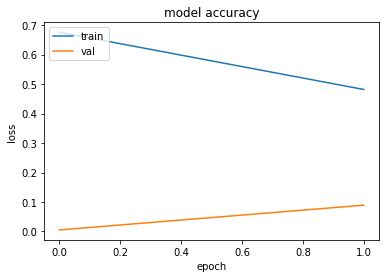

In [20]:
norm_strat = 0
print('Normalizacion:', norm_strat)
execute_test()

In [ ]:
norm_strat = 2
print('Normalizacion:', norm_strat)
execute_test()

In [ ]:
norm_strat = 3
print('Normalizacion:', norm_strat)
execute_test()

In [ ]:
norm_strat = 4
print('Normalizacion:', norm_strat)
execute_test()

Mejor metodo de normalizacion es el 2

Nos centramos ahora en la seleccion de columnas. Queremos la mayor información posible. Ahora en vez de selccionar solo una columna como target, seleccionaremos varias para proveer a nuestro futuro bucle de prediccion e inversion de mas información.

Para esto, lo mejor será tener la información del precio (suavizada o sin suavizar con SMA o EMA) y algun indicador del momento como RSI, ADX o SO.

##### Multiples features

Usaremos multiples características como objetivos de predicción. De esta manera nuestro modelo final proveera mayor información.

Usaremos indicadores ya normalizados entre ciertos valores como RSI, ADX y SO. Entre estos tres ADX suele tener mejores capacidades a la hora de indicar la fuerza de la tendencia. Utilizaremos ADX combinado con algun valor del precio:
- close
- SMA
- EMA

Esta vez cambiaremos entre disferentes monedas para dar más validez al resultado final

In [5]:
cryptos = ['ETH', 'ADA', 'BTC', 'LNK', 'LTC']

In [6]:
columns_2 = ['ADX', 'close']
columns_3 = ['ADX', 'EMA_50']
columns_4 = ['ADX', 'SMA 50']
columns_5 = ['ADX', 'EMA_200']
columns_6 = ['ADX', 'SMA 200']

target = None
norm_strat = 2

close

In [ ]:
columns = columns_2
num_features = len(columns)
for crypto in cryptos:
    crypto = crypto
    execute_test()

EMA 50

In [ ]:
columns = columns_3
num_features = len(columns)
for crypto in cryptos:
    crypto = crypto
    execute_test()

SMA 50

In [ ]:
columns = columns_4
num_features = len(columns)
for crypto in cryptos:
    crypto = crypto
    execute_test()

EMA 200

In [ ]:
columns = columns_5
num_features = len(columns)
for crypto in cryptos:
    crypto = crypto
    execute_test()

SMA 200

In [ ]:
columns = columns_6
num_features = len(columns)
for crypto in cryptos:
    crypto = crypto
    execute_test()

Tras analizar los resultados obtenidos observamos ligeras mejores cuando el valor del preico esta suavizado (menos outliers). Entre SMA y EMA parece que EMA se comporta ligeramente mejor. No es algo determinante pero seguiremos usando EMA porque cambia de forma mas rapida y de acuerda al valor real de las tendencias porque tiene mas en cuenta los ultimos precios a la hora de calcularse

Además hemos visto dificultades en la red para predecir el valor de la métrica ADX. De ahora en adelante analizaremos RSI en vez de ADX pero es posible que si no conseguimos buenas predicciones usemos solo el valor del precio, sus diferencias o la operación mas adecuada (se comenta más adelante estos dos nuevos métodos)

Antes de seguir probaremos dos metodos mas:
- Uso de la diferencia de precio
- Uso de la operación mas conveniente

In [7]:
columns_7 = ['RSI', 'close_diff_5']
columns_8 = ['RSI', 'close_diff_10']
columns_9 = ['RSI', 'close_diff_20']
columns_11 = ['op_buy', 'op_sell', 'op_hold'] # Usar softmax

Dado que actualmente tenemos puesto el parametro de dias de prediccion a 20, usaremos la columna con un calculo de diferencia de precio de 20 dias -> columns_9

Loading... ETH
Extracting columns columns for ETH
Proccessing and arranging columns for LSTM model
Input shape: (1415, 20, 2) (1415, 2)
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_26 (LSTM)               (None, 20, 25)            2800      
_________________________________________________________________
lstm_27 (LSTM)               (None, 20, 25)            5100      
_________________________________________________________________
dropout_21 (Dropout)         (None, 20, 25)            0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 20, 25)            5100      
_________________________________________________________________
dropout_22 (Dropout)         (None, 20, 25)            0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 20, 25)       

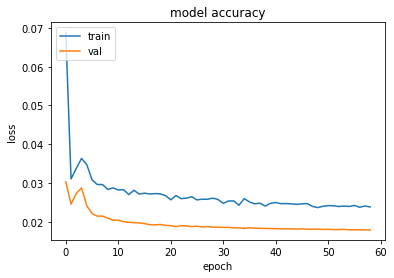

Loading... ADA
Extracting columns columns for ADA
Proccessing and arranging columns for LSTM model
Input shape: (1315, 20, 2) (1315, 2)
Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_31 (LSTM)               (None, 20, 25)            2800      
_________________________________________________________________
lstm_32 (LSTM)               (None, 20, 25)            5100      
_________________________________________________________________
dropout_25 (Dropout)         (None, 20, 25)            0         
_________________________________________________________________
lstm_33 (LSTM)               (None, 20, 25)            5100      
_________________________________________________________________
dropout_26 (Dropout)         (None, 20, 25)            0         
_________________________________________________________________
lstm_34 (LSTM)               (None, 20, 25)       

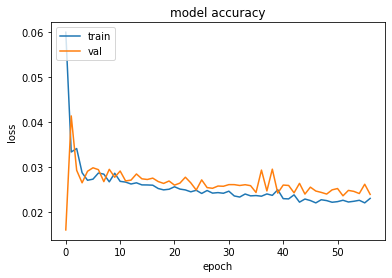

Loading... BTC
Extracting columns columns for BTC
Proccessing and arranging columns for LSTM model
Input shape: (1435, 20, 2) (1435, 2)
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_36 (LSTM)               (None, 20, 25)            2800      
_________________________________________________________________
lstm_37 (LSTM)               (None, 20, 25)            5100      
_________________________________________________________________
dropout_29 (Dropout)         (None, 20, 25)            0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 20, 25)            5100      
_________________________________________________________________
dropout_30 (Dropout)         (None, 20, 25)            0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 20, 25)       

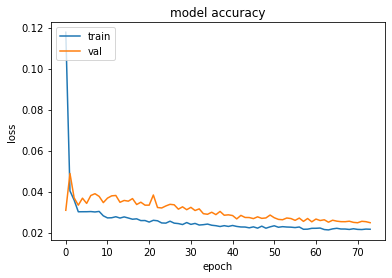

Loading... LNK
Extracting columns columns for LNK
Proccessing and arranging columns for LSTM model
Input shape: (1041, 20, 2) (1041, 2)
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_41 (LSTM)               (None, 20, 25)            2800      
_________________________________________________________________
lstm_42 (LSTM)               (None, 20, 25)            5100      
_________________________________________________________________
dropout_33 (Dropout)         (None, 20, 25)            0         
_________________________________________________________________
lstm_43 (LSTM)               (None, 20, 25)            5100      
_________________________________________________________________
dropout_34 (Dropout)         (None, 20, 25)            0         
_________________________________________________________________
lstm_44 (LSTM)               (None, 20, 25)       

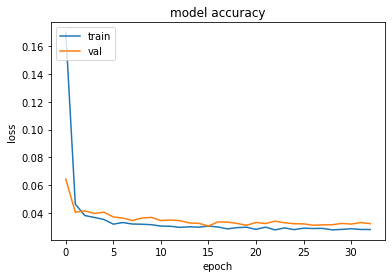

Loading... LTC
Extracting columns columns for LTC
Proccessing and arranging columns for LSTM model
Input shape: (1435, 20, 2) (1435, 2)
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_46 (LSTM)               (None, 20, 25)            2800      
_________________________________________________________________
lstm_47 (LSTM)               (None, 20, 25)            5100      
_________________________________________________________________
dropout_37 (Dropout)         (None, 20, 25)            0         
_________________________________________________________________
lstm_48 (LSTM)               (None, 20, 25)            5100      
_________________________________________________________________
dropout_38 (Dropout)         (None, 20, 25)            0         
_________________________________________________________________
lstm_49 (LSTM)               (None, 20, 25)      

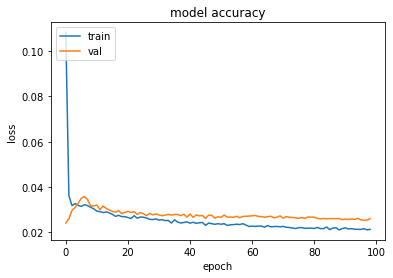

In [9]:
columns = columns_9
num_features = len(columns)

for crypto in cryptos:
    crypto = crypto
    execute_test()

Este metodo ofrece resultados aceptables en comparación con el calculo del precio como valor y por tanto usaremos este en vez del precio final como prediccion dado que si calculamos el preico final luego debemos calcular cuanto mas sube o baja con respecto al dia actual. Este método ya nos da directamente ese valor

Como podemos ver la precision de prediccion no es demasiado acertada para las metricas y por tanto evitaremos su uso en nuestro modelo final

La precision de este metodo mejorará al usar menos dias de predicción. De todas formas trataremos de mejorar la red con 20 dias en adelante antes de bajar a 10 o 5 dias

----------------------

Para calcular la operacion mas adecuada debemos cambiar la red para aceptar una activación softmax

Vamos a buscar ejemplos donde se realiza una venta o compra en la fila de test para poner mas aprueba al modelo (debido a que la mayoria son hold).



In [ ]:
columns = columns_11

activation = 'softmax'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

crypto = 'ETH'

sim = DLSimulator(crypto, prev_periods, pred_periods, columns, target,
    norm_strat, model_sel, layers, neurons, batch_size, epochs, 
    activation, loss, metrics, optimizer, initial_learning_rate, callbacks)

df = sim.get_df()
df.tail(50)

The index [-7, -9, -15, -19] provide examples with buy and sell

In [ ]:
split_indexes = [-7, -9, -15, -19]

for split_index in split_indexes:
    execute_test(split_index)

En los cuatro casos el modelo ha acertado. Consideraremos esta opción para nuestro modelo final

----------

El siguiente análisis se centrará en los hiperparametros y modelado de la red (layers, epochs, batch size, dropout). Antes de comenzar inicializaremos los parametros que dejaremos fijos durante esta etapa de analisis 

In [ ]:
#### PERIODS ####
prev_periods = 20
pred_periods = 20

#LSTM
model_sel = 0 

# Cryptos
cryptos = ['ETH', 'ADA', 'BTC', 'LNK', 'LTC']

#### NORM AND FEATURES CONFIGURATION ####
target = None
norm_strat = 2

#### COLUMNS ####
columns_11 = ['op_buy', 'op_sell', 'op_hold'] # Usar softmax
columns_12 = ['close_diff_20']


#### Hyper params ####

#activations = ['relu', 'sigmoid', 'softmax']
#losses = ['mse', 'binary_crossentropy', 'categorical_crossentropy']
#metrics_opt = ['mse', 'accuracy']
activation = 'relu'
loss = 'mse'
metrics = ['mse']
optimizer = 'adam'
initial_learning_rate = 0.01
callbacks = ['mc', 'es']
batch_size = 64
epochs = 100

Modelado:

Modelaremos la red en las capas LSTM

Modifcamos el numero de capas:

- 2 Capas
- 4 Capas
- 10 Capas

Y neuronas

- 10 Nueronas
- 50 Neuronas
- 100 Neuronas
- Gradual invertido

Trabajaremos sobre diferencia de precio de 20 dias

In [ ]:
#### HYPERPARAMETERS AND MODEL ####
layers = 4
neurons = [25, 25, 25, 25, 25]

In [ ]:
columns = columns_12
num_features = len(columns)

for crypto in cryptos:
    crypto = crypto
    execute_test()

Aplicamos el mismo numero de capas y neuronas a nuestro modelo softmax con los split ya conocidos

In [ ]:
columns = columns_11

split_indexes = [-7, -9, -15, -19]

activation = 'softmax'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

crypto = 'ETH'

for split_index in split_indexes:
    execute_test(split_index)

Hemos obtenido una buena configuración con:




Añadimos/quitamos ad hoc en el modelo capas de dropout y su activación

- Sin dropout
- Drop out alto
- Drop out medio
- Drop out bajo

No tiene sentido usar Batch norm layers en RNNs

Sin dropout

Dropout 0.1

Dropout 0.4

Dropout 0.9

Ahora modificaremos el batch size y epocas

Probaremos otras activaciones y funcion de perdidas

Haremos backtesting para probar a añadir varias caracteristicas y sacar como target la diferencia de precio. Obtendremos mejor resultado una vez aplicado el modelado de red y los hiperparametros mas eficiantes segun hemos analizado?

In [ ]:
target = ''

#### GRU

Probaremos el mejor modelado e hiperparametros ya vistos pero con GRU

In [ ]:
model_sel = 1

#### Final models to use

- 
- 

In [ ]:
# DICT with parameters for best models



## Complete simulation

Complete strategy definition. Let the machine work through all the dataset